# Notebook 9: Phase 5 - Real-World Validation (Kiểm định Thực tế 2020-2023)

## 1. Giới thiệu và Mục tiêu

**Mục tiêu chính:**
Kiểm định **Mô hình Lai (Hybrid Model)** đã huấn luyện trên dữ liệu thực tế từ **2020 đến 2023**.

**Vấn đề Tự tương quan (Autocorrelation):**
- Mô hình huấn luyện phụ thuộc lớn vào **Lag Features** (ví dụ: CO2 năm trước).
- Dữ liệu từ World Bank/OWID cần được lấy từ quá khứ (2015-2023) để tính toán các biến trễ (Lag) này chính xác cho năm 2020-2023.
- Nếu thiếu biến Lag (điền 0), mô hình sẽ dự báo sai lệch hoàn toàn (gần về 0).


In [1]:
import pandas as pd
import numpy as np
import wbdata
import joblib
import json
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from datetime import datetime

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8')

MODEL_DIR = '../models'
DATA_DIR = '../data/processed'
RESULTS_DIR = '../data/results'

In [2]:
def load_artifacts():
    print("Loading models...")
    try:
        with open(os.path.join(MODEL_DIR, 'scaler_stats.json'), 'r') as f:
            scaler_stats = json.load(f)
        ridge_model = joblib.load(os.path.join(MODEL_DIR, 'hybrid_lr_model.pkl'))
        xgb_model = joblib.load(os.path.join(MODEL_DIR, 'hybrid_xgb_residual_model.pkl'))
        print("Done.")
        return ridge_model, xgb_model, scaler_stats
    except Exception as e:
        print(f"Error loading artifacts: {e}")
        return None, None, None

ridge_model, xgb_model, scaler_stats = load_artifacts()

Loading models...
Done.


In [3]:
INDICATORS = {
    'NY.GDP.PCAP.PP.KD': 'gdp_per_capita',  
    'EG.ELC.ACCS.ZS': 'Access to electricity (% of population)', 
    'EG.FEC.RNEW.ZS': 'Renewable energy share in the total final energy consumption (%)', 
    'EG.USE.PCAP.KG.OE': 'Primary energy consumption per capita', 
    'SP.POP.TOTL': 'Population'
}

def fetch_data(start_year=2015, end_year=2023):
    # Lấy dữ liệu từ 2015 để có thể tính lag cho 2020
    print(f"Fetching WB data ({start_year}-{end_year})...")
    try:
        df_wb = wbdata.get_dataframe(INDICATORS, country='all', date=(datetime(start_year, 1, 1), datetime(end_year, 12, 31)))
        df_wb = df_wb.reset_index().rename(columns={'country': 'Entity', 'date': 'Year'})
        df_wb['Year'] = df_wb['Year'].astype(int)
        # Load OWID for Ground Truth & Lag Features
        print("Fetching OWID CO2 data...")
        df_owid = pd.read_csv("https://raw.githubusercontent.com/owid/co2-data/master/owid-co2-data.csv")
        df_owid = df_owid[['country', 'year', 'co2']]
        df_owid = df_owid.rename(columns={'country': 'Entity', 'year': 'Year', 'co2': 'Value_co2_emissions_kt_by_country'})
        df_owid['Value_co2_emissions_kt_by_country'] *= 1000 # Mt -> kt
        
        return df_wb, df_owid
    except Exception as e:
        print(f"Fetch error: {e}")
        return None, None

In [4]:
def preprocess(df_wb, df_owid):
    # 1. Cleaning & Merge
    if 'Primary energy consumption per capita' in df_wb.columns:
        df_wb['Primary energy consumption per capita (kWh/person)'] = df_wb['Primary energy consumption per capita'] * 11.63
        df_wb.drop(columns=['Primary energy consumption per capita'], inplace=True)
    
    country_map = {
        'Viet Nam': 'Vietnam', 'Egypt, Arab Rep.': 'Egypt', 'Iran, Islamic Rep.': 'Iran',
        'Korea, Rep.': 'South Korea', 'United States': 'United States', 'China': 'China',
        'Russian Federation': 'Russia'
    }
    df_wb['Entity'] = df_wb['Entity'].replace(country_map)
    df_owid['Entity'] = df_owid['Entity'].replace(country_map)
    
    df = pd.merge(df_wb, df_owid, on=['Entity', 'Year'], how='inner')
    
    # 2. Impute Basics
    df = df.sort_values(['Entity', 'Year'])
    df = df.groupby('Entity', group_keys=False).apply(lambda x: x.ffill().bfill())
    
    # 3. Static Features (Density, Land Area) from Local File
    try:
        local_df = pd.read_csv('../data/processed/common_preprocessed.csv')
        # Normalize column names to avoid newline issues
        local_df.columns = [c.replace('\n', '') for c in local_df.columns]
        
        # Map static features
        if 'Density(P/Km2)' in local_df.columns:
             static = local_df[['Entity', 'Density(P/Km2)', 'Land Area(Km2)', 'Latitude', 'Longitude']].drop_duplicates('Entity')
             # Rename back to match scaler_stats if needed (scaler_stats has \n)
             static = static.rename(columns={'Density(P/Km2)': 'Density\n(P/Km2)'})
             df = pd.merge(df, static, on='Entity', how='left')
    except Exception as e:
        print(f"Warning: Could not load static features: {e}")
        
    # Fill Numeric NaNs
    num_cols = df.select_dtypes(include=np.number).columns
    df[num_cols] = df[num_cols].fillna(0) # Fallback

    # 4. CREATE LAGS (Critical Step!)
    print("Generating Lag Features...")
    cols_to_lag = ['Value_co2_emissions_kt_by_country', 'gdp_per_capita', 'Primary energy consumption per capita (kWh/person)']
    for col in cols_to_lag:
        if col in df.columns:
            df[f'{col}_lag1'] = df.groupby('Entity')[col].shift(1)
            
    # Drop rows where Lags are NaN (first year 2015)
    df = df.dropna(subset=[f'{c}_lag1' for c in cols_to_lag if c in df.columns])
    
    return df

In [5]:
def predict_and_eval(df, ridge, xgb, scaler_stats):
    # Filter for Evaluation Period (2020-2023)
    df_eval = df[(df['Year'] >= 2020) & (df['Year'] <= 2023)].copy()
    
    if df_eval.empty:
        print("No data left for 2020-2023 after processing!")
        return

    X = df_eval.copy()
    
    # 1. Scale Features
    for col, stats in scaler_stats.items():
        if col in X.columns:
            X[col] = (X[col] - stats['mean']) / stats['std']
            
    # 2. One-Hot Entity
    req_feats = ridge.feature_names_in_
    for f in req_feats:
        if f.startswith('Entity_'):
             e = f.replace('Entity_', '')
             X[f] = (X['Entity'] == e).astype(int)
        elif f not in X.columns:
             X[f] = 0
             
    X_final = X[req_feats]
    
    # 3. Predict
    try:
        # Ridge
        pred_ridge = ridge.predict(X_final)
        # XGB (Handle Feature Names)
        try:
            pred_xgb = xgb.predict(X_final)
        except:
            pred_xgb = xgb.predict(X_final.values)
            
        df_eval['Predicted_CO2'] = pred_ridge + pred_xgb
        
        # Clip negative predictions
        df_eval['Predicted_CO2'] = df_eval['Predicted_CO2'].clip(lower=0)
        
        # 4. Metrics
        y_true = df_eval['Value_co2_emissions_kt_by_country']
        y_pred = df_eval['Predicted_CO2']
        
        r2 = r2_score(y_true, y_pred)
        b_mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1))) * 100 # Add 1 to avoid ZeroDiv
        median_mape = np.median(np.abs((y_true - y_pred) / (y_true + 1))) * 100
        
        print(f"Validation 2020-2023 Results:")
        print(f"R2 Score: {r2:.4f}")
        print(f"Mean MAPE (Approx): {b_mape:.2f}%")
        print(f"Median MAPE: {median_mape:.2f}%")
        
        # 5. Plot
        plt.figure(figsize=(8,8))
        plt.scatter(y_true, y_pred, alpha=0.5)
        plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.title('True vs Predicted CO2 (2020-2023)')
        plt.show()
        
        # Top Country Analysis
        top = df_eval.groupby('Entity')[['Value_co2_emissions_kt_by_country', 'Predicted_CO2']].mean().sort_values('Value_co2_emissions_kt_by_country', ascending=False).head(5)
        print(top)
        top.plot(kind='bar', figsize=(10,6))
        plt.title("Top 5 Emitters Average (2020-2023)")
        plt.show()
        
    except Exception as e:
        print(f"Prediction Error: {e}")

Fetching WB data (2015-2023)...


Fetching OWID CO2 data...


C:\Users\MaiVu\AppData\Local\Temp\ipykernel_9340\73851036.py:19: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('Entity', group_keys=False).apply(lambda x: x.ffill().bfill())
C:\Users\MaiVu\AppData\Local\Temp\ipykernel_9340\1586823285.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  X[f] = (X['Entity'] == e).astype(int)
C:\Users\MaiVu\AppData\Local\Temp\ipykernel_9340\1586823285.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

Generating Lag Features...
Validation 2020-2023 Results:
R2 Score: 0.9923
Mean MAPE (Approx): 4923.21%
Median MAPE: 27.77%


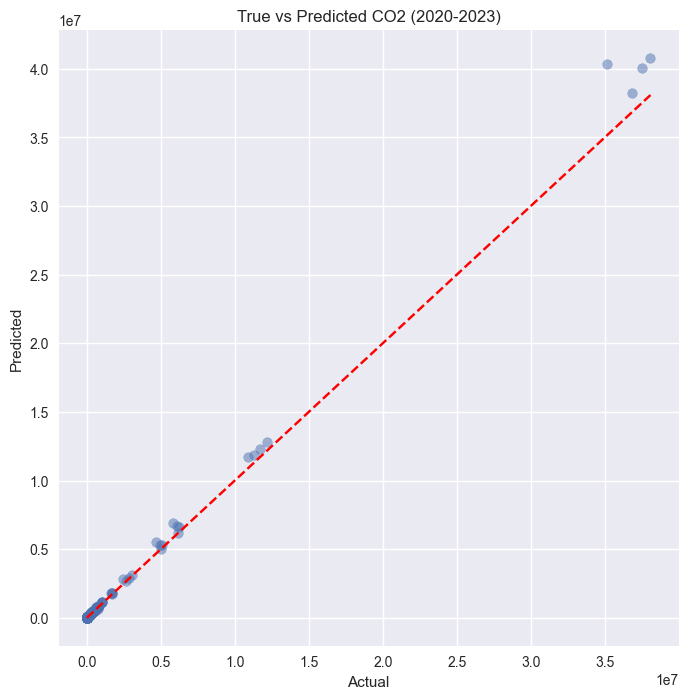

               Value_co2_emissions_kt_by_country  Predicted_CO2
Entity                                                         
World                                36911726.25   3.986757e+07
China                                11516184.75   1.215987e+07
North America                         6078976.75   6.605464e+06
United States                         4920968.75   5.267492e+06
India                                 2748099.50   2.875654e+06


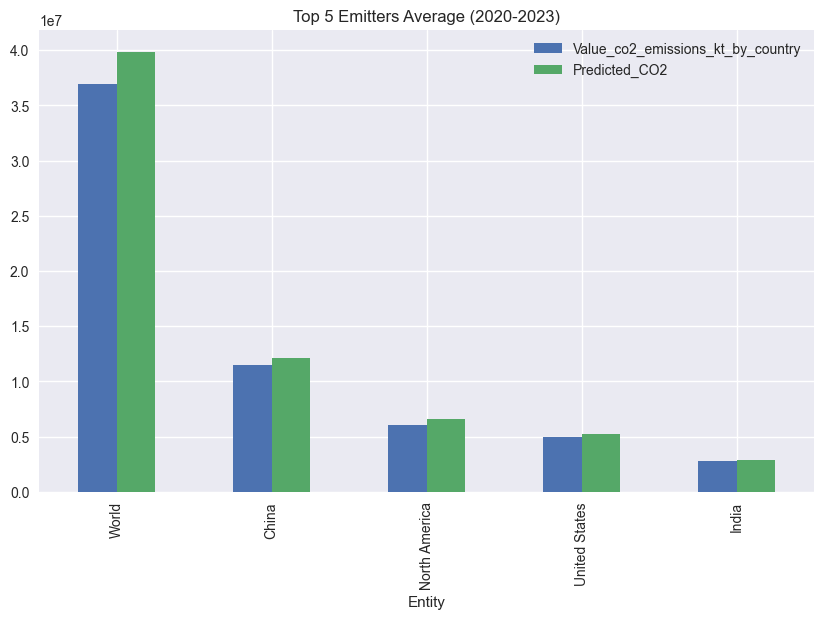

In [6]:
df_wb_raw, df_owid_raw = fetch_data()
if df_wb_raw is not None:
    df_proc = preprocess(df_wb_raw, df_owid_raw)
    predict_and_eval(df_proc, ridge_model, xgb_model, scaler_stats)